## Test PSF measurement in the stack

Done in 27.part 2, but now we need to understand why there's a in increase in RMS at middling densities prior to 
a decrease and then a big increase again.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


Make a couple of test images to test the PSF measurement on...

In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.], variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=2350, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=21)

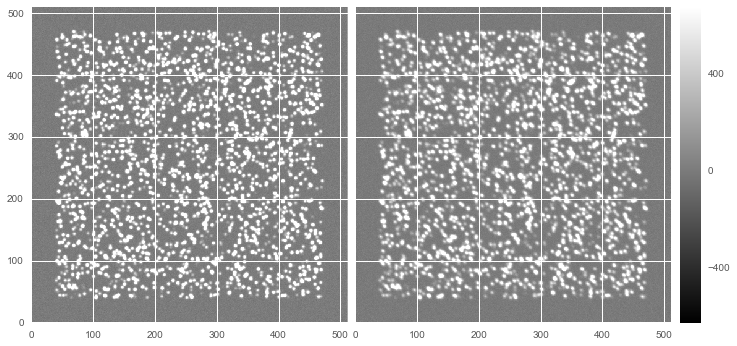

In [3]:
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj.im1.im, testObj.im2.im))

Load results from 27.part 2.

207
208
209
210
211
212
213
214
215


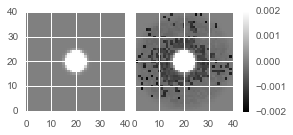

In [11]:
import cPickle; import gzip
testResults1 = cPickle.load(gzip.GzipFile('27. psf measurement evaluation - part 2.p.gz', 'rb'))
for i in range(len(testResults1)):
    if testResults1[i]['nSources'] == 2350:
        print i
tr = testResults1[207]
dit.plotImageGrid((tr['inputPsf1'], tr['psf1']), clim=(-0.002,0.002))

In [38]:
im1 = testObj.im1.asAfwExposure()
res1 = dit.measurePsf(im1, detectThresh=5.0, measurePsfAlg='psfex')
psf1 = dit.afwPsfToArray(res1.psf, im1) #.computeImage()

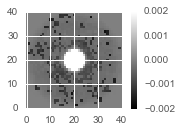

In [39]:
dit.plotImageGrid((psf1,), clim=(-0.002,0.002))

6.46907057764
10.2549455044
1681.0
0.00290410539012


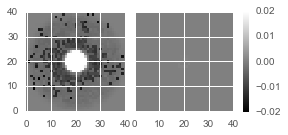

In [58]:
psf1a = tr['psf1'].copy() #/ np.abs(psf2.getArray()).sum()
#psf1anorm = psf1a[(np.abs(psf1a)>=1e-3) | (psf1a<0)].sum()
psf1a /= psf1a.max() #psf1anorm
rms1 = np.sqrt(((psf1a - tr['inputPsf1'])**2.).mean())
print rms1 * 100.
print psf1a.sum()

weights = psf1a**2.
weights /= weights.mean()
print weights.sum()
rms1weighted = np.sqrt(((psf1a - tr['inputPsf1']/tr['inputPsf1'].max())**2. * weights).mean())
print rms1weighted

dit.plotImageGrid((psf1a,((psf1a - tr['inputPsf1']/tr['inputPsf1'].max())**2. * weights)), clim=(-0.02,0.02))

0.999998968923 1.0 1.00000010432


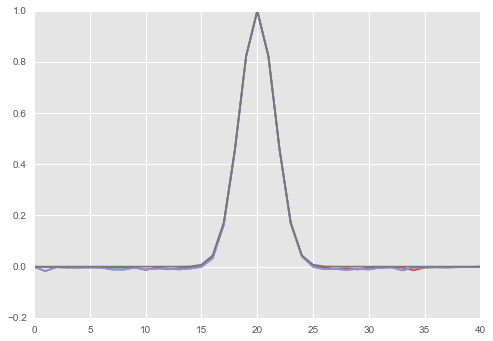

In [56]:
print psf1.sum(), tr['inputPsf1'].sum(), tr['psf1'].sum()
plt.plot(psf1[20,:]/psf1.max())
plt.plot(psf1a[20,:])
plt.plot(tr['psf1'][20,:]/tr['psf1'].max())
plt.plot(tr['inputPsf1'][20,:]/tr['inputPsf1'].max())